In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [27]:
import ipywidgets as widgets
import numpy as np
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import math,pywt
import utilities
from huffman import HuffmanCoding

from ipywidgets import interact
from scipy import fftpack
from style import *
from camera import CameraReader, display_frame
from IPython.display import display
from PIL import Image
from tqdm import tqdm_notebook

def color2bw(img):
    return np.dot(img, [0.299, 0.587, 0.114]) 

In [4]:
size = 2

def eliminar_ruido(frame):
    #Mascara temporal
    S_img = fftpack.fftshift(fftpack.fft2(frame))
    S_img[220-size:220+size,421:423] = 0
    S_img[260-size:260+size,425:427] = 0
    r_frame = 1 + np.abs(fftpack.ifft2(fftpack.ifftshift(S_img))).astype(np.uint8)
    #espectre=np.log(np.abs(S_img)+1).astype(np.uint8)
    return r_frame

In [5]:
from scipy.signal import fftconvolve, convolve2d
size = 2
Cf= np.array([[1,1,1,1],
   [2,1,-1,-2],
   [1,-1,-1,1],
   [1,-2,2,1]])

sa,sb,sc = 1/4,np.sqrt(10)/20,1/10
Sf = [[sa,sb,sa,sb],
     [sb,sc,sb,sc],
      [sa,sb,sa,sb],
     [sb,sc,sb,sc]]

Ci = [[1,1,1,1],
     [1,0.5,-0.5,-1],
     [1,-1,-1,1],
     [0.5,-1,1,-0.5]]
     
def comprimir(frame):
   
    r_frame = convolve2d(frame,Cf)
    r_frame = convolve2d(r_frame,np.transpose(Cf))
    #espectre=np.log(np.abs(S_img)+1).astype(np.uint8)
    return r_frame.astype(np.uint8)

def descomprimir(frame):
    d_frame = convolve2d(np.transpose(Ci),frame)
    d_frame = convolve2d(d_frame,Ci)
    return d_frame.astype(np.uint8)

In [6]:
cam = CameraReader()
vid_height, vid_width = cam.get_resolution()
print("Resolución del video: {0}x{1}p".format(vid_width, vid_height))
print("Cuadros por segundo: {0}".format(cam.get_fps()))

out = widgets.Image(layout=widgets.Layout(width=str(vid_width), 
                                          height=str(vid_height)))

def replay():
    frame_cnt = 0
    
    for frame in cam:
        # Implemente una función que limpie los frames
        #if frame_cnt%2 !=0:
        #scipy.misc.imsave("filtered{0}.jpg".format(frame_cnt),frame)
        frame_limpio = eliminar_ruido(frame)
        #print(sys.getsizeof(frame_limpio))  #getsizeof retorna el tamaño en Bytes

        # Implemente una función que comprima los frames
        #frame_comprimido = comprimir(frame_limpio)
        #print(sys.getsizeof(frame))

        # Implemente una función que descomprima los frames
        #frame = descomprimir(frame_comprimido)
        #print(cam.error(frame_limpio))  # Error de compresión
        display_frame(out, frame_limpio)
        
        frame_cnt+=1
        if frame_cnt==50:
            break
    

button = widgets.Button(
    description='Replay Video',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Replay',
    icon='check'
)

def on_click_button(b):
    
    replay()
    

button.on_click(on_click_button)

display(button,out)


Iniciando lector de camara
OpenCV version: major: 4, minor: 1, subminor: 0
Resolución del video: 848x480p
Cuadros por segundo: 29.97002997002997


Button(description='Replay Video', icon='check', style=ButtonStyle(), tooltip='Replay')

Image(value=b'', layout="Layout(height='480', width='848')")

<IPython.core.display.Javascript object>


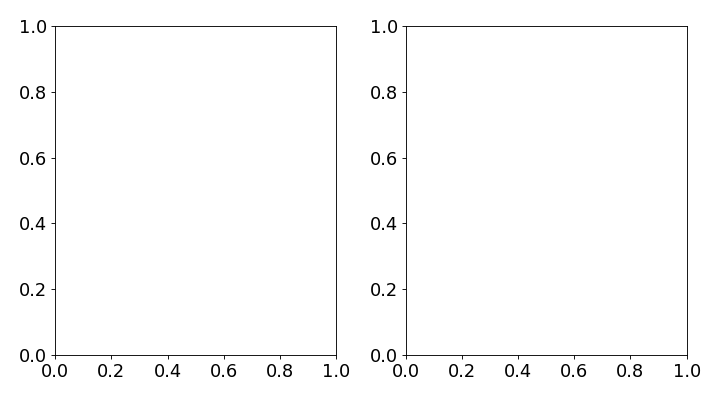

interactive(children=(IntSlider(value=10, description='size', max=20, min=1), Output()), _dom_classes=('widget…

<function __main__.update(size)>

In [7]:
size = 1
fig, ax = plt.subplots(1, 2, figsize=(9, 5), tight_layout=True)
def update(size):
        img_building = np.array(plt.imread("outfile.jpg".format(i)))
        S_img = fftpack.fftshift(fftpack.fft2(img_building))

        S_img[220-size:220+size,421:423] = 0
        S_img[260-size:260+size,425:427] = 0
        #S_img[380-size:380+size,425:427] = 0
        #S_img[440-size:440+size,425:427] = 0
        im = ax[0].imshow(np.log(1+np.abs(S_img)))
        #fig.colorbar(im, ax=ax[0], orientation='horizontal')
        im = ax[1].imshow(np.abs(fftpack.ifft2(fftpack.ifftshift(S_img))))
        #fig.colorbar(im, ax=ax[1], orientation='horizontal')
        

interact(update,size=widgets.IntSlider(min=1, max=20, value=10))

In [8]:
noise_p1 = 220,422
noise_p2 = 260,426
noise_p3 = 380,426
noise_p4 = 440,26


<IPython.core.display.Javascript object>


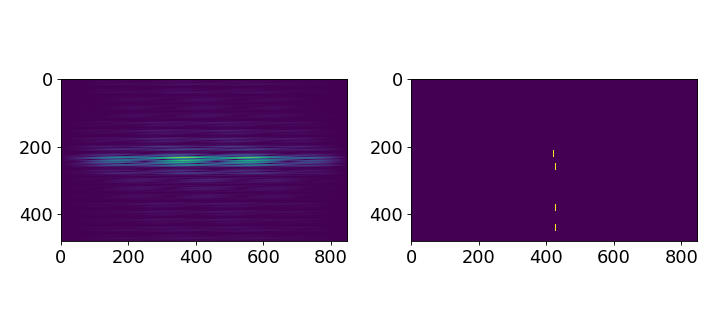

interactive(children=(IntSlider(value=10, description='size', max=20, min=1), Output()), _dom_classes=('widget…

<function __main__.update(size)>

In [9]:
#Testing ground

size = 1
img_building = np.array(plt.imread("outfile.jpg"))
fig, ax = plt.subplots(1, 2, figsize=(9, 4), tight_layout=True)



#x[380-size:380+size,425:427] = 1
#x[440-size:440+size,425:427] = 1

def update(size):
    x = np.zeros(shape=(480,848)).astype(np.uint8)
    x[220-size:220+size,421:423] = 255
    x[260-size:260+size,425:427] = 255
    x[380-size:380+size,425:427] = 255
    x[440-size:440+size,425:427] = 255
    S_img = fftpack.ifftshift(fftpack.ifft2(x))

    im = ax[0].imshow(np.log(1+np.abs(S_img)))
    #fig.colorbar(im, ax=ax[0], orientation='horizontal')
    im = ax[1].imshow(np.abs(fftpack.fft2(fftpack.fftshift(S_img))))
    #fig.colorbar(im, ax=ax[1], orientation='horizontal')
    #scipy.misc.imsave("filtered.jpg",np.abs(fftpack.ifft2(fftpack.ifftshift(S_img))))

interact(update,size=widgets.IntSlider(min=1, max=20, value=10))

In [11]:
def Q(x,h=8):
    return (x//h)*8+(h/2)

In [10]:
##########################
##Muestra las imagenes del espectro en secuencia
##########################
out = widgets.Image(layout=widgets.Layout(width=str(848), 
                                          height=str(480)))

display(out)

for i in tqdm_notebook(range(900)):
    img_building = Image.open("spectres/filtered{0}.jpg".format(i))
    display_frame(out,np.array(img_building).astype(np.uint8))

Image(value=b'', layout="Layout(height='480', width='848')")

In [32]:
data = np.array(Image.open("filtered.jpg")).astype(np.uint8)
out = widgets.Image(layout=widgets.Layout(width=str(848), 
                                          height=str(480)))

#display(out)
#display_frame(out,data.astype(np.uint8))

with open("final.txt","rb") as f:
    a = np.load(f)
alto = a.shape[0]
ancho = a.shape[1]
#LL = a[:alto//2,:ancho//2]
#LH = a[:alto//2,ancho//2:ancho]
#HL = a[alto//2:alto,:ancho//2]
#HH = a[alto//2:alto,ancho//2:ancho]
#print("data: ",sys.getsizeof(data))
#LL, (LH, HL, HH) = pywt.dwt2(data, wavelet='db1')

##cuantizar 
#llq,hlq,lhq,hhq = Q(LL),Q(HL),Q(LH),Q(HH)
a = Q(a)
np.savetxt('mio.txt',a,fmt='%1.1f')

path = "mio.txt"

h = HuffmanCoding(path)

output_path = h.compress()
print("Compressed file path: " + output_path)

decom_path = h.decompress(output_path)
print("Decompressed file path: " + decom_path)






#with open("mio_decompressed.txt","rb") as f:
    #a = np.load(f)
a = np.loadtxt("mio_decompressed.txt")

##aqui tiene que ir una descuantizacion


print(a.shape)
alto = a.shape[0]
ancho = a.shape[1]
LL = a[:alto//2,:ancho//2]
LH = a[:alto//2,ancho//2:ancho]
HL = a[alto//2:alto,:ancho//2]
HH = a[alto//2:alto,ancho//2:ancho]
real = utilities.inversa(LL,HL,LH,HH)
out = widgets.Image(layout=widgets.Layout(width=str(848), 
                                          height=str(480)))

display(out)
display_frame(out,real.astype(np.uint8))

Compressed
Compressed file path: mio.bin
Decompressed
Decompressed file path: mio_decompressed.txt
(480, 848)
(240, 424)
lhrep (480, 848)


Image(value=b'', layout="Layout(height='480', width='848')")

In [ ]:
#####
###Conversion de las imagenes del espectro a video ~60mb
#####
import cv2
import os
from tqdm import tqdm
import glob
#TODO
image_folder = 'spectres/*'
video_name = 'video/video_spec.avi'#save as .avi
#is changeable but maintain same h&w over all  frames
width=848
height=480 
#this fourcc best compatible for avi
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
video=cv2.VideoWriter(video_name,fourcc, cam.get_fps(), (width,height))



for i in tqdm((sorted(glob.glob(image_folder),key=os.path.getmtime))):
     x=cv2.imread(i)
     video.write(x)

cv2.destroyAllWindows()
video.release()